# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №5 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 17 декабря 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 декабря, -4 балла после 06:00 24 декабря, -6 баллов после 06:00 31 декабря -8 баллов  после 06:00 7 января


Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

**Из чего состоит задание:**

###### Теоретические вопросы (2 балла)

###### Реализация алгоритма кластеризации (6 баллов)

###### Боевое применение (2 балла)




**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

# Определяем, что вам досталось

Укажите свою фамилию на русском языке в поле ниже.

In [1]:
import hashlib

def lucky_hash(text):
    return int(hashlib.md5(text.encode('utf-8')).hexdigest()[:8], 16) 

USER_NAME = u"Иванов".lower()

ALGORITHMS = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - число кластеров)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - число кластеров, linkage)",]

print ("Имплементируйте алгоритм кластеризации %s"\
% (
    ALGORITHMS[lucky_hash(USER_NAME[::-1]) % 2]
) )

Имплементируйте алгоритм кластеризации Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - число кластеров, linkage)


Не стоит переживать из-за Вашего варианта. Технически оба алгоритма несложно реализовать.  EM алгоритма бояться не стоит, Вам будет нужно просто реализовать уже выведенные формулы для E и M шагов.

In [170]:
import time
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Теоретическое введение


Основная задача кластерного анализа — разбиение исходного набора объектов на группы (кластеры) таким образом, чтобы объекты в группе были похожи друг на друга, а объекты из разных групп - отличались. 

В этой работе мы будем реализовывать один из двух популярных методов кластеризации: разделение смеси нормальных распределений или агломеративную кластеризацию. 

## Смесь нормальных распределений



Предполагаем, что наши данные порождены смесью $k$ нормальных распределений, то есть 

$$ p(\mathbf{x}) = \sum_k \pi_k \mathcal{N}(\mathbf{x} | \mathbf{\mu}_k, \mathbf{\Sigma}_k) $$,


где $\mathcal{N}$ - многомерное нормальное распределение размерности ${D}$:

$$\mathcal{N(\mathbf{x} | \mathbf{\mu}, \mathbf{\Sigma}}) = \frac{1}{(2 \pi)^{D/2}} \frac{1}{|\mathbf{\Sigma}|^{1/2}} \exp \left\{-\frac{1}{2}(\mathbf{x} - \mathbf{\mu})^T \mathbf{\Sigma^{-1}} (\mathbf{x} - \mathbf{\mu})\right\}$$

**Параметры**  


${D}$-мерный вектор средних

$$\mathbf{\mu}$$

$D \times D$-мерная матрица ковариации   (симметричная)


$$\mathbf{\Sigma} = E[(\mathbf{x} - \mathbf{\mu})(\mathbf{x} - \mathbf{\mu})^T]$$



Необходимо оценить параметры $\pi_k, \mathbf{\mu_k}, \mathbf{\Sigma_k} $ для всех компонент смеси.  Сделать это можно с помощью EM алгоритма - алгоритма, который находит оценку максимального правдоподобия в задаче со скрытыми переменными. 

## Expectation Maximization

**I** До цикла проинциализировать случайно  $\mu_k, \Sigma_k, \pi_k$ ($\pi_k$ должны суммироваться в 1)

**E** Expectation: при фиксированных $\mu_k, \Sigma_k, \pi_k$
$$
p(z_k = 1| x_n ) = \gamma(z_{nk}) = \frac{\pi_k \mathcal{N} (\mathbf{x}_n | \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \mathcal{N} (\mathbf{x}_n | \mu_j, \Sigma_j)}
$$
**M** Maximization: при фиксированных $\gamma(z_{nk})$
$$
N_k = \sum_{n=1}^N \gamma(z_{nk}), \;\; \mu_k = \frac 1 {N_k} \sum_{n=1}^N \gamma(z_{nk}) \mathbf{x}_n
$$
$$
\Sigma_k = \frac 1 {N_k} \sum_{n=1}^N \gamma(z_{nk}) (\mathbf{x}_n - \mu_k)(\mathbf{x}_n - \mu_k)^T
$$
$$
\pi_k = \frac{N_k}{N}
$$
**S** Остановиться при достижении сходимости

Номер кластера для $n$ объекта будем брать по принципу maximum a-posteriori, то есть относить объект к тому кластеру, у которого максимальна апостериорная вероятность:
$$ k_n =  \arg\underset{k}\max  p(z_k = 1| x_n ) =  \arg\underset{k}\max \gamma(z_{nk}) $$

## Агломеративная кластеризация

Иерархические алгоритмы кластеризации строят на выборке систему вложенных разбиений.  Наиболее часто испоьзуемые иерархические алгоритмы - агломеративные алгоритмы, которые строят ирархию по восходящей, то есть от момента, когда все элементы являются отдельными кластерами, до того момента, пока вся выборка не станет одним кластером.

Сам алгоритм описать можно примерно так:

* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер


В данной работе Вам предлагается реализовать три варианта расстояний между кластерами, по которым Вы определяете пару для слияния: 
* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Complete linkage
$$ d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Average linkage
$$ d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

Для простоты будем использовать евклидово расстояние между объектами.



Для того, чтобы на втором этапе нам не пересчитывать заново расстояния между всеми парами кластеров, можно использовать Формулы Ланса-Вильямса, которые позволяют посчитать расстояние между кластерами после объединения, используя только расстояния между кластерами до объедения.  Таким образом, достаточно будет посчитать расстояния только между всеми одноэлементными кластерами (первый этап), а затем пересчитывать расстояния при их объединении через 
формулы Ланса-Вильямса. 

Общая  формула выглядит так:
$$ d(C_i \cup C_j, C_k) = a_i \cdot d(C_i, C_k) + a_j \cdot d(C_j, C_k) + b \cdot d(C_i, C_j) + c \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

Можно показать, что все относительно разумные кластерные расстояния можно описать данной формулой. 

Для интересущих нас linkage:

* single-linkage       $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =  - \frac{1}{2} $

* complete-linkage     $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =   \frac{1}{2} $

* average-linkage       $a_i = \frac{|C_i|}{|C_i \cup C_j|}, a_j =  \frac{|C_j|}{|C_i \cup C_j|}, b = 0, c = 0 $



# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Сходимость kmeans.

Метод kmeans является частным случаем EM алгоритма и наиболее простым в обосновании сходимости. Докажите, что kmeans всегда сходится, и итераций не будет превышать $k^N$, где $k$ $-$ число кластеров, $N$ $-$ число объектов

Подсказка: Вам стоит рассмотреть функционал, который минимизирует алгоритм, и подумать, как он изменяется на E шаге и на M шаге.



***Ваше решение здесь***

Для каждого элемента (1...N) нужно выбрать один из кластеров (1...k), полный перебор всех возможных вариантов до нахождения оптимальной ситуации займет $k^N$ итераций

В алгоритме k-means центроид кластера каждый раз будет смещаться в сторону уменьшения дисперсии между объектами и реальным матожиданием

Задача 2. Сходимость EM.

Разобравшись со сходимостью kmeans, можно догадаться и до ответа про EM алгоритм.

При каком условии на правдоподобие системы EM алгоритм будет  сходиться?



***Ваше решение здесь***

Правдоподобие должно быть ограничено, в частности, в случае с k-means должно существовать математическое ожидание

Задача 3. Формулы Ланса-Вильямса.

Формулы Ланса-Вильямса крайне удобны для быстрого пересчта расстояний в агломеративной кластеризации. Давайте докажем  формулы для single и complete linkage. 

Докажите, что:

$d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $


$d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $




***Ваше решение здесь***

Если $d_{\min}(U, S) > d_{\min}(V, S)$ т.е. $d_{\min}(U \cup V, S) = d_{\min}(V, S)$ 

то после раскрытия модуля, получаем требуемое:


$ d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2}d_{\min}(U, S) + \frac{1}{2}d_{\min}(V, S) $

$ d_{\min}(U \cup V, S) = d_{\min}(V, S) $

Остальное аналогично

# Реализация алгоритма кластеризации  (6 баллов)

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`. 

In [900]:
from sklearn.base import BaseEstimator, ClusterMixin


class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """
    
    def __init__(self, linkage='single_linkage', **kwargs):
        """
        Please add necessary algoritm parameters to class constructor.
        """
        self.linkage = linkage
        if linkage == 'single_linkage':
            self.linkage_ = self.single_linkage
        if linkage == 'complete_linkage':
            self.linkage_ = self.complete_linkage
        if linkage == 'average_linkage':
            self.linkage_ = self.average_linkage
        return
    
    def single_linkage(self, U_i, V_i, S):
        d_US = self.distances[U_i][S]
        d_VS = self.distances[V_i][S]
        return 0.5 * d_US + 0.5 * d_VS - 0.5 * np.abs(d_US - d_VS)

    def complete_linkage(self, U_i, V_i, S):
        d_US = self.distances[U_i][S]
        d_VS = self.distances[V_i][S]
        return 0.5 * d_US + 0.5 * d_VS + 0.5 * np.abs(d_US - d_VS)

    def average_linkage(self, U_i, V_i, S):
        a_U = self.hier[self.clusters[U_i]][3]
        a_V = self.hier[self.clusters[V_i]][3]
        a_UV = a_U + a_V
        return a_U / a_UV * self.distances[U_i][S] + \
                a_V / a_UV * self.distances[V_i][S]
        
    def combine_(self, i):
        N = self.distances.shape[0]
        cond = np.where(self.distances == np.min(self.distances))
        U_i, V_i = cond[0][0], cond[1][0]
        U, V = self.clusters[U_i], self.clusters[V_i]

        dist = self.distances[U_i, V_i]
        mask = np.ones(self.clusters.shape[0], dtype=bool)
        mask[U_i], mask[V_i] = False, False
        d_UV = np.append(self.linkage_(U_i, V_i, mask), np.inf)
        self.clusters = self.clusters[mask]

        self.distances = self.distances[:, mask][mask]
        buf = np.zeros((N - 1, N - 1))
        buf[:-1, :-1] = self.distances
        buf[:, -1], buf[-1] = d_UV, d_UV
        self.distances = buf

        self.hier.append([U, V, dist, 
                             self.hier[U][3] + self.hier[V][3]])
        self.clusters = np.append(self.clusters, i)
        
    def fit(self, x, y=None):
        """
        Use data matrix x to compute model parameters
        """
        self.x_len = len(x)
        self.distances = smt.pairwise_distances(x)
        self.hier = [[0, 0, 0, 1] for i in range(self.x_len)]
        np.fill_diagonal(self.distances, np.inf)
        self.clusters = np.arange(self.x_len)

        for i in range(self.x_len, 2 * self.x_len - 1):
            self.combine_(i)
        self.hier = self.hier[self.x_len:]
        return self
    
    def predict(self, x, n = None):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        if n is None:
            n = 2

        self.fit(x)    
        
        clusters = set(self.hier[-1][:2])
        buf = self.hier[-1][1]
        for i in [item[:2] for item in self.hier[-2:-n:-1]]:
            clusters.update(i[:2])
            clusters.remove(buf)
            buf = max(clusters)
            
        clusters_ind = dict(sort([(j, i) for (i, j) in enumerate(clusters)], axis=0))
        
        labels = np.zeros(self.x_len)
        k = np.arange(len(self.hier) - n + 1)
        for current_clust in range(self.x_len):
            ind = current_clust
            for i in k:
                if current_clust in self.hier[i][:2]:
                    current_clust = (i + self.x_len)
            labels[ind] = clusters_ind[current_clust]
        
        return labels


In [887]:
%time
kk = Clustering()
kk.predict(X_train)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.87 µs


array([ 0.,  0., ...,  1.,  1.])

In [587]:
%time
ss = AgglomerativeClustering(n_clusters=2)
ss.fit(X_train)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func='deprecated')

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

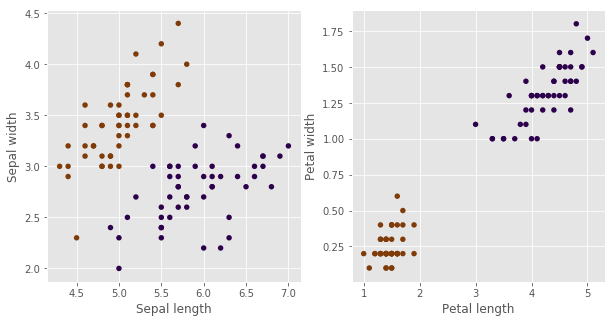

In [893]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

(array([ 50.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  50.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

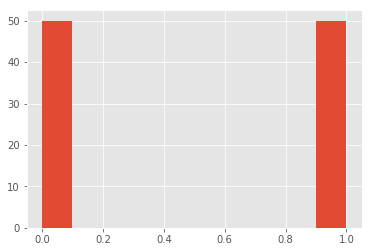

In [892]:
plt.hist(pred_iris)

In [891]:
%time pred_iris = Clustering().predict(X_train, n=2)
print ("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_train, pred_iris))

CPU times: user 52.2 ms, sys: 2.64 ms, total: 54.8 ms
Wall time: 27 ms
Adjusted Rand index for iris is: 1.00


In [646]:
shape(kk.hier)

(149, 4)

In [678]:
k = np.arange(len(kk.hier) - 1)
k

array([  0,   1, ..., 146, 147])

In [832]:
n = 2
labels = np.zeros(len(X_train))
k = np.arange(len(kk.hier) - n + 1)
for current_clust in range(len(X_train)):
    ind = current_clust
    for i in k:
        if current_clust in kk.hier[i][:2]:
            current_clust = (i + len(X_train))
    labels[ind] = clusters_ind[current_clust]
labels

array([ 1.,  1., ...,  0.,  0.])

In [862]:
clusters = set(kk.hier[-1][:2])
buf = kk.hier[-1][1]
for i in [item[:2] for item in kk.hier[-2:-n:-1]]:
    clusters.update(i[:2])
    clusters.remove(buf)
    buf = max(clusters)

clusters_ind = dict(sort([(j, i) for (i, j) in enumerate(clusters)], axis=0))
clusters_ind

{294: 0, 297: 1}

In [771]:
sort

{295, 296}

In [746]:
kk.hier

[[101, 142, 0.0, 2],
 [7, 39, 0.099999999999954528, 2],
 [128, 132, 0.099999999999954528, 2],
 [0, 17, 0.099999999999990055, 2],
 [10, 48, 0.099999999999990055, 2],
 [9, 34, 0.10000000000002558, 2],
 [27, 28, 0.14142135623727031, 2],
 [4, 37, 0.14142135623729543, 2],
 [63, 91, 0.14142135623729543, 2],
 [80, 81, 0.14142135623729543, 2],
 [82, 92, 0.14142135623729543, 2],
 [95, 96, 0.14142135623729543, 2],
 [1, 12, 0.14142135623732055, 2],
 [2, 47, 0.14142135623732055, 2],
 [8, 38, 0.14142135623732055, 2],
 [19, 21, 0.14142135623732055, 2],
 [29, 30, 0.14142135623734567, 2],
 [57, 93, 0.14142135623734567, 2],
 [116, 137, 0.14142135623734567, 2],
 [65, 75, 0.14142135623739593, 2],
 [127, 138, 0.14142135623744617, 2],
 [40, 153, 0.15731321849708296, 3],
 [49, 151, 0.15731321849709323, 3],
 [45, 162, 0.17071067811867177, 3],
 [88, 161, 0.17320508075691152, 3],
 [94, 99, 0.17320508075693203, 2],
 [112, 139, 0.17320508075693203, 2],
 [123, 126, 0.17320508075693203, 2],
 [25, 155, 0.1866025403

{'icoord': [[55.0, 55.0, 65.0, 65.0],
  [75.0, 75.0, 85.0, 85.0],
  [115.0, 115.0, 125.0, 125.0],
  [165.0, 165.0, 175.0, 175.0],
  [155.0, 155.0, 170.0, 170.0],
  [185.0, 185.0, 195.0, 195.0],
  [235.0, 235.0, 245.0, 245.0],
  [225.0, 225.0, 240.0, 240.0],
  [255.0, 255.0, 265.0, 265.0],
  [285.0, 285.0, 295.0, 295.0],
  [305.0, 305.0, 315.0, 315.0],
  [290.0, 290.0, 310.0, 310.0],
  [275.0, 275.0, 300.0, 300.0],
  [260.0, 260.0, 287.5, 287.5],
  [232.5, 232.5, 273.75, 273.75],
  [215.0, 215.0, 253.125, 253.125],
  [205.0, 205.0, 234.0625, 234.0625],
  [335.0, 335.0, 345.0, 345.0],
  [325.0, 325.0, 340.0, 340.0],
  [219.53125, 219.53125, 332.5, 332.5],
  [190.0, 190.0, 276.015625, 276.015625],
  [365.0, 365.0, 375.0, 375.0],
  [355.0, 355.0, 370.0, 370.0],
  [415.0, 415.0, 425.0, 425.0],
  [405.0, 405.0, 420.0, 420.0],
  [445.0, 445.0, 455.0, 455.0],
  [485.0, 485.0, 495.0, 495.0],
  [475.0, 475.0, 490.0, 490.0],
  [465.0, 465.0, 482.5, 482.5],
  [450.0, 450.0, 473.75, 473.75],
  [435

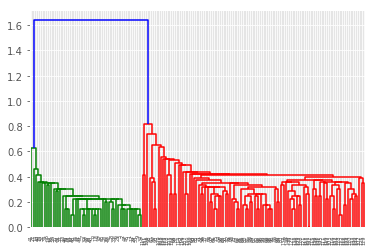

In [872]:
dendrogram(kk.hier)

In [533]:
kk.distances

array([[ inf]])

In [394]:
a = np.array([1, 2, 3, 4, 5])
np.append(a, np.inf)

array([  1.,   2.,   3.,   4.,   5.,  inf])

In [217]:
np.argsort(kk.distances)

array([[ 0, 17,  4, ..., 83, 52, 77],
       [ 1, 34, 45, ..., 83, 52, 77],
       [ 2, 47,  3, ..., 83, 52, 77],
       ..., 
       [97, 74, 71, ..., 42, 22, 13],
       [98, 57, 93, ..., 50, 77, 52],
       [99, 96, 94, ..., 14, 13, 22]])

In [201]:
X_train[kk.clusters[0]]

array([[ 5.1,  3.5,  1.4,  0.2]])

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [10.0, 10.0, 32.5, 32.5]],
 'dcoord': [[0.0, 0.14142135623730953, 0.14142135623730953, 0.0],
  [0.0, 0.14142135623730964, 0.14142135623730964, 0.0],
  [0.0, 0.90553851381374162, 0.90553851381374162, 0.14142135623730964],
  [0.14142135623730953,
   1.4142135623730951,
   1.4142135623730951,
   0.90553851381374162]],
 'ivl': ['0', '1', '4', '2', '3'],
 'leaves': [0, 1, 4, 2, 3],
 'color_list': ['g', 'r', 'r', 'b']}

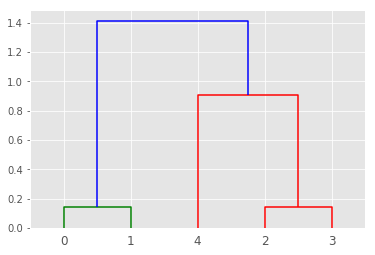

In [556]:
from scipy.cluster.hierarchy import dendrogram, linkage

data = [[0., 0.], [0.1, -0.1], [1., 1.], [1.1, 1.1], [1, 2]]

Z = linkage(data)
dendrogram(Z)

In [557]:
Z

array([[ 0.     ,  1.     ,  0.14142,  2.     ],
       [ 2.     ,  3.     ,  0.14142,  2.     ],
       [ 4.     ,  6.     ,  0.90554,  3.     ],
       [ 5.     ,  7.     ,  1.41421,  5.     ]])

In [348]:
l1, l2 = np.where(ps == np.min(ps))[0]

In [351]:
x = np.arange(9.).reshape(3, 3)
x

array([[ 0.,  1.,  2.],
       [ 3.,  4.,  5.],
       [ 6.,  7.,  8.]])

In [292]:
def single_linkage(U, V, S):
        d_US = dists[U][S]
        d_VS = dists[V][S]
        return 0.5 * d_US + 0.5 * d_VS - 0.5 * np.abs(d_US - d_VS)

In [296]:
k = smt.pairwise_distances(data)
np.fill_diagonal(k, np.inf)
first, second = np.where(k == np.min(k))[0]
dists = k
k

array([[        inf,  0.14142136,  1.41421356,  1.55563492,  2.23606798],
       [ 0.14142136,         inf,  1.42126704,  1.56204994,  2.28473193],
       [ 1.41421356,  1.42126704,         inf,  0.14142136,  1.        ],
       [ 1.55563492,  1.56204994,  0.14142136,         inf,  0.90553851],
       [ 2.23606798,  2.28473193,  1.        ,  0.90553851,         inf]])

In [306]:
N = 3
a = np.random.rand(N,N)
%timeit b = np.hstack((a,np.zeros((a.shape[0],1))))

4.93 µs ± 115 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [312]:
a

array([[ 0.23163068,  0.12724439,  0.51066742],
       [ 0.46554346,  0.05680024,  0.76858784],
       [ 0.1210191 ,  0.21627003,  0.6595572 ]])

In [313]:
b = np.zeros((a.shape[0],a.shape[1]+1)); b[:,:-1] = a

In [329]:
b = np.zeros((a.shape[0] + 1, a.shape[1] + 1))
b[:-1, :-1] = a
b[:, -1] = np.array([0, 1, 2, np.inf])
b[-1] = np.array([0, 1, 2, np.inf])
b

array([[ 0.23163068,  0.12724439,  0.51066742,  0.        ],
       [ 0.46554346,  0.05680024,  0.76858784,  1.        ],
       [ 0.1210191 ,  0.21627003,  0.6595572 ,  2.        ],
       [ 0.        ,  1.        ,  2.        ,         inf]])

In [304]:
%timeit np.c_[ a, np.zeros(N)]

26.7 µs ± 2.15 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [236]:
np.fill_diagonal(ps, np.inf)
np.argmin(ps, axis=1)

array([17, 12, 47, 47,  0, 18, 47, 39, 38, 34, 48,  7,  1, 38, 33, 33, 10,
        0,  5, 21, 31, 19,  6, 26, 11, 34, 23, 28, 27, 30, 29, 20, 33, 32,
        9, 49, 10,  4,  8,  7, 17,  8, 38, 26, 46,  1, 19,  2, 10,  7, 52,
       56, 50, 89, 58, 66, 51, 93, 54, 89, 93, 96, 92, 91, 82, 75, 84, 92,
       87, 80, 85, 97, 83, 63, 97, 65, 58, 52, 91, 81, 81, 80, 92, 72, 66,
       56, 52, 68, 95, 53, 94, 63, 82, 57, 99, 96, 95, 74, 57, 96])

In [263]:
k = np.where(ps == np.min(ps))[0]


[7, 39]

In [245]:
linkage = np.zeros((100-1, 4))
linkage

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  

In [22]:
X_train = iris['data'][:100]

In [108]:
x = [[2,3, 4], [3,1, 2], [6,5, 1]]

In [233]:
ps = smt.pairwise_distances(X_train)

In [ ]:
ps

In [229]:
np.argmin(np.partition(ps, 2)[:, 1])

7

In [87]:
from scipy.spatial import distance as dt

In [93]:
def compute_distances_no_loops( X):
    dists = -2 * np.dot(X, X.T) + np.sum(X**2, axis=1) + np.sum(X**2, axis=1)[:, np.newaxis]
    return dists

In [95]:
compute_distances_no_loops(np.array(x))

array([[0, 2, 8],
       [2, 0, 2],
       [8, 2, 0]])

In [139]:
sklearn_aggl = AgglomerativeClustering()

In [140]:
sklearn_aggl.fit(X_train)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func='deprecated')

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [10.0, 10.0, 32.5, 32.5]],
 'dcoord': [[0.0, 0.14142135623730953, 0.14142135623730953, 0.0],
  [0.0, 0.14142135623730964, 0.14142135623730964, 0.0],
  [0.0, 0.90553851381374162, 0.90553851381374162, 0.14142135623730964],
  [0.14142135623730953,
   1.4142135623730951,
   1.4142135623730951,
   0.90553851381374162]],
 'ivl': ['0', '1', '4', '2', '3'],
 'leaves': [0, 1, 4, 2, 3],
 'color_list': ['g', 'r', 'r', 'b']}

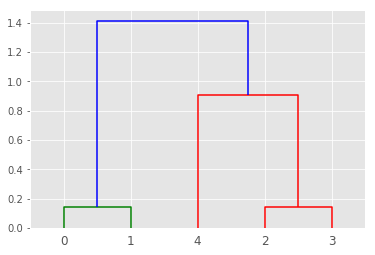

In [149]:
from scipy.cluster.hierarchy import dendrogram, linkage

data = [[0., 0.], [0.1, -0.1], [1., 1.], [1.1, 1.1], [1, 2]]

Z = linkage(data)
dendrogram(Z)

In [156]:
Z

array([[ 0.        ,  1.        ,  0.14142136,  2.        ],
       [ 2.        ,  3.        ,  0.14142136,  2.        ],
       [ 4.        ,  6.        ,  0.90553851,  3.        ],
       [ 5.        ,  7.        ,  1.41421356,  5.        ]])

In [158]:
np.vstack((a, np.array([1,2,3])))

array([[ 0.        ,  1.        ,  0.14142136],
       [ 2.        ,  3.        ,  0.14142136],
       [ 4.        ,  6.        ,  0.90553851],
       [ 5.        ,  7.        ,  1.41421356],
       [ 1.        ,  2.        ,  3.        ]])

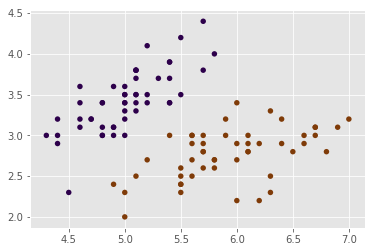

In [20]:
pl.scatter(X_train[:, 0], X_train[:, 1], c=sklearn_aggl.labels_, cmap=pl.cm.PuOr, lw=0, s=30)

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [901]:
pred_iris = Clustering().predict(x_iris)
pred_iris = [ 0 ] * len(y_iris)
print ("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

Adjusted Rand index for iris is: 0.00


In [899]:
pred_iris

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [6]:
# Давайте проверим, как справляются sklearn реализации
sklearn_gmm = GaussianMixture(n_components=2)
gmm_t0 = time.time()
sklearn_gmm.fit(x_iris)
gmm_diff = time.time() - gmm_t0
gmm_score = smt.adjusted_rand_score(y_iris, sklearn_gmm.predict(x_iris))

sklearn_aggl = AgglomerativeClustering(n_clusters=2)
aggl_t0 = time.time()
aggl_pred = sklearn_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print ("GMM score {}. GMM time {}. AGGL score {}. AGGL time {}".format(gmm_score, gmm_diff, aggl_score, aggl_diff))

GMM score 1.0. GMM time 0.029532194137573242. AGGL score 1.0. AGGL time 0.034522056579589844


Сверьте Ваш алгоритм с этими числами. Уверен, что у Вас получится не хуже!

# Боевое применение (2  балла)


Алгоритмы кластеризации прекрасны тем, что они позволяют быстро понять, как устроены наши данные. Давайте применим Ваш алгоритм для анализа реальной задачи!

Важное замечание: в этой части задания студенту самому предлагается разобраться с данными и их форматом в качестве полезного упраженения. Не принимайте это близко к сердцу :)

Ввозьмем датасет различных стран.  
Данные нужно скачать тут https://data.worldbank.org/data-catalog/world-development-indicators.   


Подход следующий: фиксируем год, для каждой страны берём индикаторы по зафиксированному году, кластеризуем по индикаторам. 
Разбиение должно быть объяснимым, в противном случае, скорее всего нужно лучше настроить параметры кластеризации.   

Необходимо показать, какие страны попали в общий кластер в и объяснить из-за каких признаков это произошло. Если страны были в одном кластере, а спустя несколько лет разъехались по разным кластерам, попробуйте это объяснить. 

In [7]:
# Место для Вашего кластерного анализа

In [8]:
# Не переживайте, мне тоже было тяжело разобраться с данными

# Контрольные вопросы
Постарайтесь максимально развернуто и честно ответить на вопросы. Они охватывают тему алгоритмов кластеризации и скорее нужны преподавателям, чтобы понимать, что именно Вы усвоили плохо. Надеюсь, они подскажут, что именно в теме Вы не понимаете или наоборот порадают, что Вы все знаете ^_^

* Опишите, пожалуйста, для каких прикладных задач Вы бы стали использовать методы кластеризации?

***Ваше ответ здесь***

* Какие преимущества и недостатки Вы видите у следуюших алгоритмов кластеризации: kmeans, dbscan, агломеративная кластеризация?

***Ваше ответ здесь***

* На лекции было показано, что EM алгоритм находит оценку максимального правдоподобия в задаче со сккрытыми переменными. Из курса мат. статистики Вы можете знать, оценка максимального правдоподобия "оптимальная" во многих смыслах. В каких же случаях тогда не следует применять метод максимального правдоподобия?

***Ваше ответ здесь***

* Многие алгоритмы анализа данных страдают "проклятием" размерности. Страдают ли этим проклятием алгоритмы кластеризации? Если да, то как бы Вы с этим боролись?

***Ваше ответ здесь***

* Представьте, что у Вас есть набор текстовых документов, и Вы хотите разбить эти документы на тематики - новости, спорт, кулинария, кино и так далее. Размеченной выборки у Вас нет, только сами тексты документов. Какие алгоритмы и какие признаки Вы бы использовали для решения данной задачи?

***Ваше ответ здесь***

* Теперь представьте, что небольшая часть Ваших текстов была размечена людьми, но большая часть так и осталась без таргета. Смогли ли бы Вы использовать эти данные для улучения качества кластеризации? (эта задача называется semi-supervised learning)

***Ваше ответ здесь***

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***